In [2]:
# eda packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# modeling packages
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from xgboost.sklearn import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# feature engineering
from statsmodels.tools.tools import add_constant
from scipy import stats
from mlxtend.preprocessing import minmax_scaling

# supress the warnings
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [3]:
sale_price=pd.read_csv('/content/drive/MyDrive/Prodigy InfoTech/PRODIGY_ML_01/sample_submission.csv')
sale_price.head(2)

,Id,SalePrice
0,1461,122173.313104
1,1462,140561.538683


In [4]:
train = pd.read_csv('/content/drive/MyDrive/Prodigy InfoTech/PRODIGY_ML_01/train.csv')
train.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [5]:
test=pd.read_csv('/content/drive/MyDrive/Prodigy InfoTech/PRODIGY_ML_01/test.csv')
test.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal


In [6]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
# categorical fields
categorical_data=list(train.columns[(train.dtypes == 'string') | (train.dtypes == 'object')])+['OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars']

# numerical fields
numerical_data=list(set(train.columns)-set(categorical_data))
# remove ID and sales price
numerical_data.remove('SalePrice')
numerical_data.remove('Id')

In [8]:
train.Id.nunique()

1460

In [9]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


In [10]:
# Missing Values
missing_values=list(train.columns[train.isnull().any()])

for m in missing_values:
#     check what percentage of columns are null
    null_percent=round(train[m].isnull().sum()*100/len(train),2)
#     only show those columns will majority null values
    if null_percent > 90:
        print(f"The column {m} contains {null_percent}% null values")
        print(train[m].value_counts(dropna=False))
        print()

The column Alley contains 93.77% null values
Alley
NaN     1369
Grvl      50
Pave      41
Name: count, dtype: int64

The column PoolQC contains 99.52% null values
PoolQC
NaN    1453
Gd        3
Ex        2
Fa        2
Name: count, dtype: int64

The column MiscFeature contains 96.3% null values
MiscFeature
NaN     1406
Shed      49
Gar2       2
Othr       2
TenC       1
Name: count, dtype: int64



In [11]:
fig = px.violin(train, y="SalePrice", box=True, points='all', template="plotly_white", color_discrete_sequence=["#77B0FF"],title='Sales Price Distribution')
fig.update_traces(quartilemethod="exclusive")
fig.update_xaxes(title_text='',showgrid=False)
fig.update_yaxes(title_text='Sale Price',showgrid=False)
fig.show()

In [12]:
train=train.sort_values(by='OverallQual')
fig = px.box(train, x="SalePrice",y='OverallQual',color='OverallQual',width=900, height=1000,
            hover_data={'OverallQual':True},template="plotly_white", orientation="h",
            color_discrete_sequence=px.colors.sequential.dense)
# fig.update_yaxes(type='OverallQual')
# fig.update_traces(quartilemethod="exclusive")
fig.update_xaxes(title_text='Sales Price')
fig.update_yaxes(title_text='Overall Quality')
fig.update_layout(yaxis = dict(tickmode = 'linear'),
                title={'text':'Sale Price by House Overall Quality',
                        'xanchor': 'center',
                        'yanchor': 'top',
                        'x': .5,
                        'y': .97},
                legend_traceorder="reversed")
fig.show()

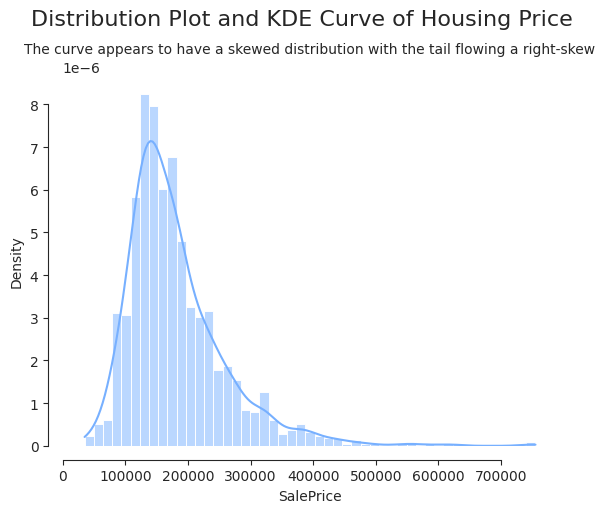

In [13]:
sns.set_style("ticks")
sns.histplot(train['SalePrice'],kde=True,color='#77B0FF',stat='density')
plt.suptitle('Distribution Plot and KDE Curve of Housing Price',y=1.02,fontsize=16)
plt.title('The curve appears to have a skewed distribution with the tail flowing a right-skew',y=1.04,fontsize=10)
sns.despine(offset=10, trim=True)
plt.show()

# **Data Cleanse**

In [14]:
# fill in missing data
for c in categorical_data:
    train[c] = train[c].fillna('n/a')
    test[c] = test[c].fillna('n/a')

for n in numerical_data:
    train[n] = train[n].fillna(0)
    test[n] = test[n].fillna(0)

In [15]:
# check if any categorical data points have over 90% in a single category
selected_categories=[]
new_categories=[]
for c in categorical_data:
    if train[c].value_counts(normalize=True).between(.9, 1).any():
        print(f"The column {c} contains over 90% in a single category")
        print(train[c].value_counts(dropna=False))
        print()
#         convert the column into a binary column
        most_occuring_category=str(train[c].value_counts(normalize=True).index[0])
        train[c+'_'+most_occuring_category]=np.where(train[c]==most_occuring_category,1,0)
        test[c+'_'+most_occuring_category]=np.where(test[c]==most_occuring_category,1,0)
        new_categories.append(c+'_'+most_occuring_category)
        selected_categories.append(c)

The column Street contains over 90% in a single category
Street
Pave    1454
Grvl       6
Name: count, dtype: int64

The column Alley contains over 90% in a single category
Alley
n/a     1369
Grvl      50
Pave      41
Name: count, dtype: int64

The column Utilities contains over 90% in a single category
Utilities
AllPub    1459
NoSeWa       1
Name: count, dtype: int64

The column LandSlope contains over 90% in a single category
LandSlope
Gtl    1382
Mod      65
Sev      13
Name: count, dtype: int64

The column Condition2 contains over 90% in a single category
Condition2
Norm      1445
Feedr        6
Artery       2
RRNn         2
PosN         2
RRAe         1
RRAn         1
PosA         1
Name: count, dtype: int64

The column RoofMatl contains over 90% in a single category
RoofMatl
CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Roll          1
Metal         1
Membran       1
ClyTile       1
Name: count, dtype: int64

The column Heating contains over 90% in a single cate

In [16]:
# convert numerical data points that have over 75% of the values = 0 to boolean
for n in numerical_data:
    zero_percentage = (train[n] == 0).mean()
    if zero_percentage >= 0.75:
        print(f"feature {n} converted to boolean for having over 75% of the values = 0")
        train[f'is_{n}'] = np.where(~train[n].isna() & train[n].notnull() & train[n] > 0, 1, 0)
        test[f'is_{n}'] = np.where(~test[n].isna() & test[n].notnull() & test[n] > 0, 1, 0)

feature ScreenPorch converted to boolean for having over 75% of the values = 0
feature LowQualFinSF converted to boolean for having over 75% of the values = 0
feature EnclosedPorch converted to boolean for having over 75% of the values = 0
feature 3SsnPorch converted to boolean for having over 75% of the values = 0
feature PoolArea converted to boolean for having over 75% of the values = 0
feature BsmtFinSF2 converted to boolean for having over 75% of the values = 0
feature MiscVal converted to boolean for having over 75% of the values = 0


<ipython-input-16-7394a0f72cef>:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-16-7394a0f72cef>:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-16-7394a0f72cef>:7: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-16-7394a0f72cef>:6: PerformanceWarning:

Da

# **Correlations**

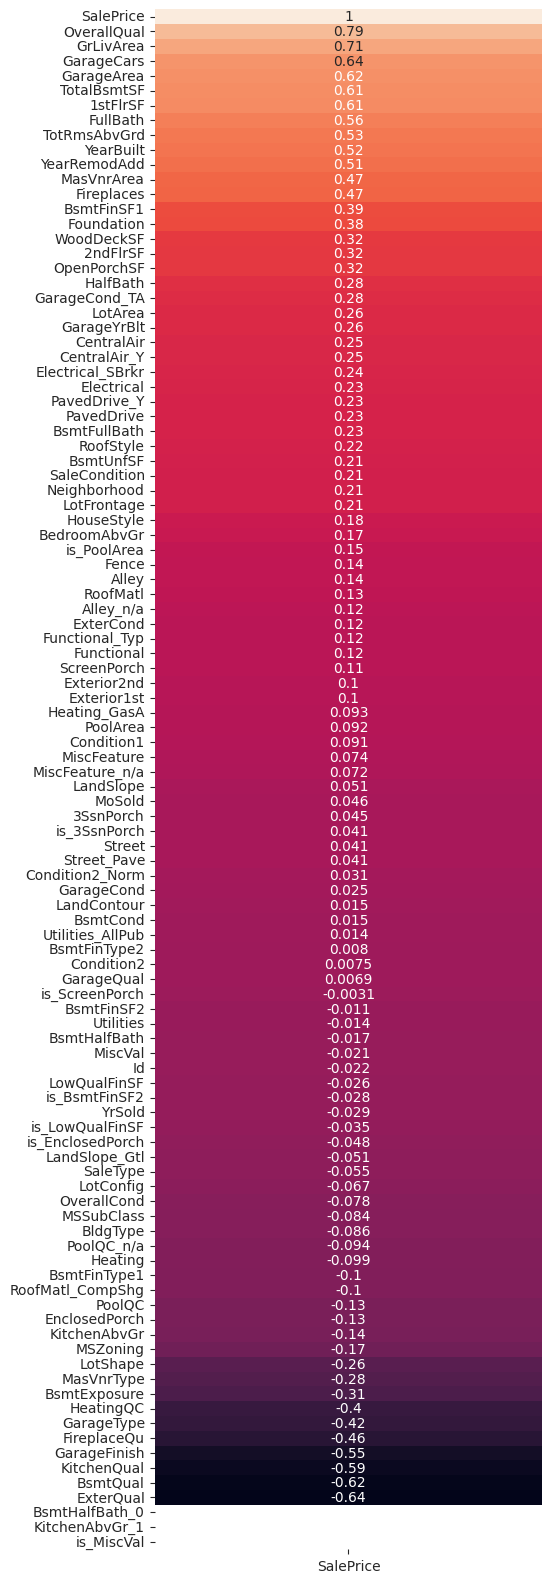

In [17]:
#encode cat vars
for c in categorical_data:
    train[c] = train[c].astype('category')
    train[c] = train[c].cat.codes

# check the correlation matrix
plt.figure(figsize=(5, 20))
matrix=train.corr()[['SalePrice']]
matrix=matrix.sort_values(by='SalePrice',ascending=False)
sns.heatmap(matrix,annot=True,cbar=False)
plt.show()

In [18]:
null_correlations=list(matrix[matrix['SalePrice'].isna()].index.values)
train=train.drop(null_correlations,axis=1)
test=test.drop(null_correlations,axis=1)

In [19]:
matrix=train.corr()

# are there any highly correlated data points?
highly_corr = pd.DataFrame(columns=['data_point1', 'data_point2', 'corr_coef'])

# get only the lower triangle
lower_triangle = np.tril(matrix, k=-1)
lower_triangle_df = pd.DataFrame(lower_triangle, index=matrix.index, columns=matrix.columns)

# for every unique pair check if the correlation coef is about abs(.9)
for row_feat, row_data in lower_triangle_df.iterrows():
    for col_feat, corr_coef in row_data.items():
        if (abs(corr_coef) > .9) & (row_feat != col_feat):
            highly_corr = pd.concat([highly_corr,pd.DataFrame({'data_point1': row_feat,'data_point2': col_feat,'corr_coef': round(corr_coef, 4)},index=[0])], ignore_index=True)
if len(highly_corr)==0:
    print("There are no highly correlated pairs")
else:
    highly_corr.sort_values(by="corr_coef")

# **Feature Engineering**
### **Non-Linear Transformations**

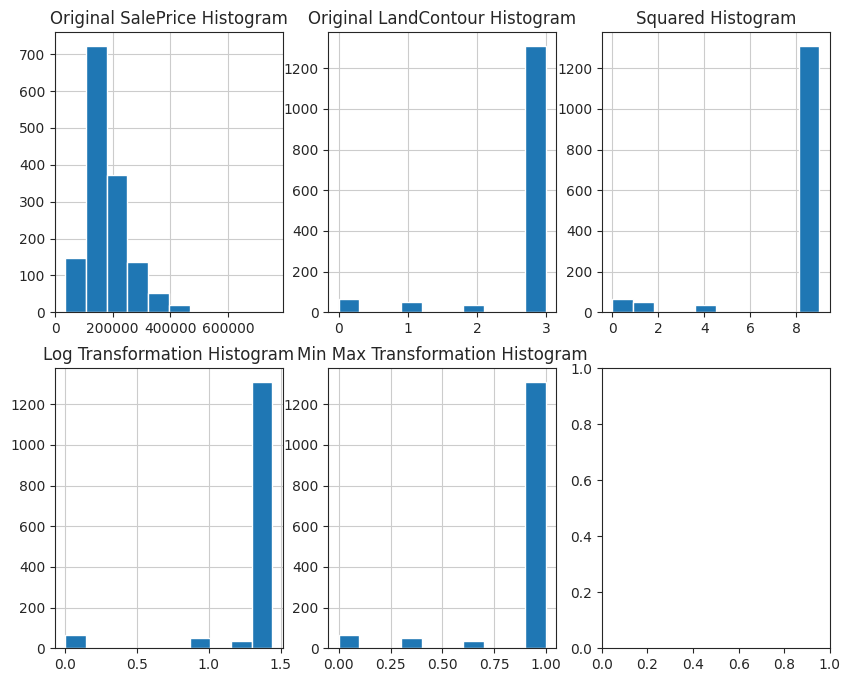

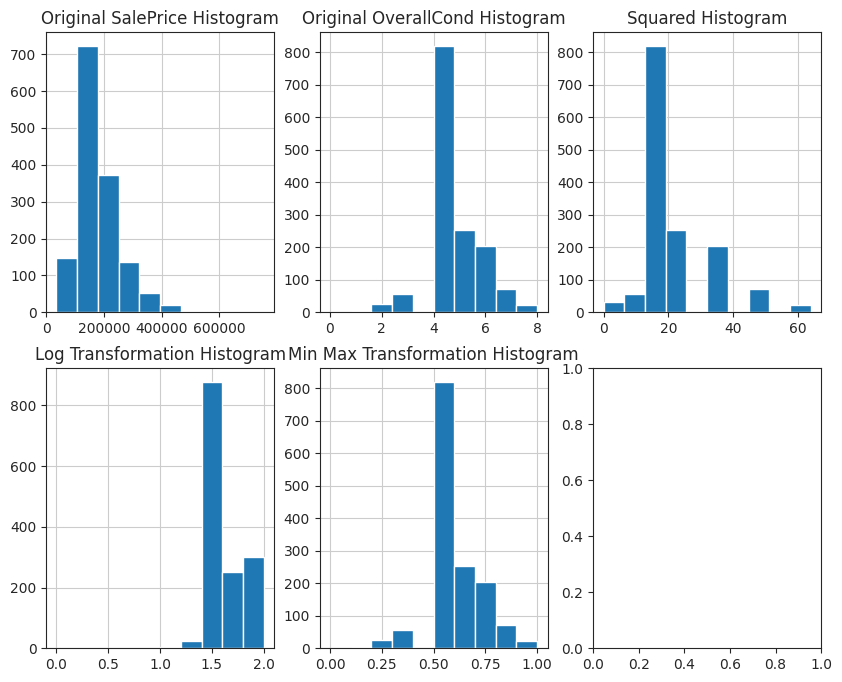

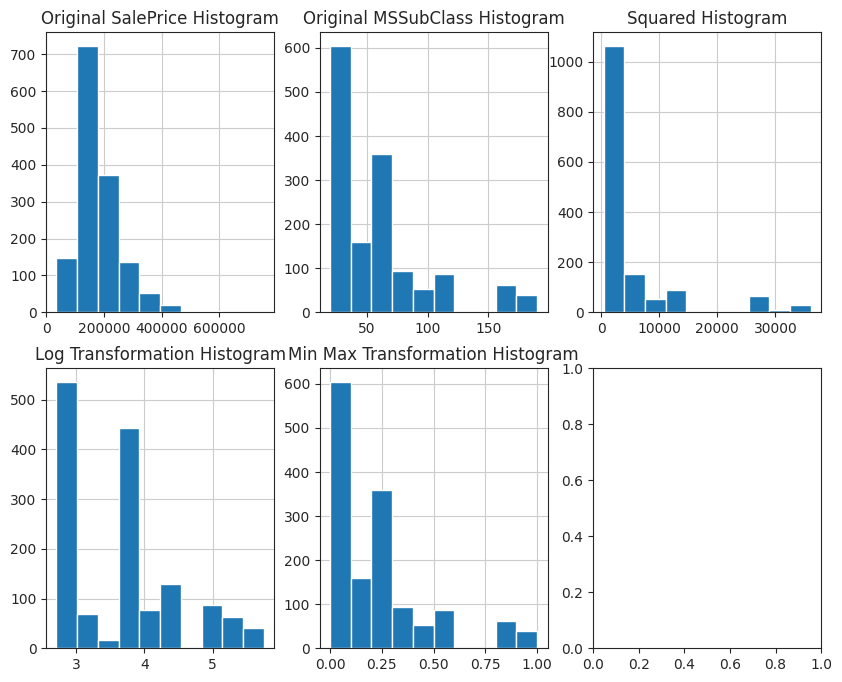

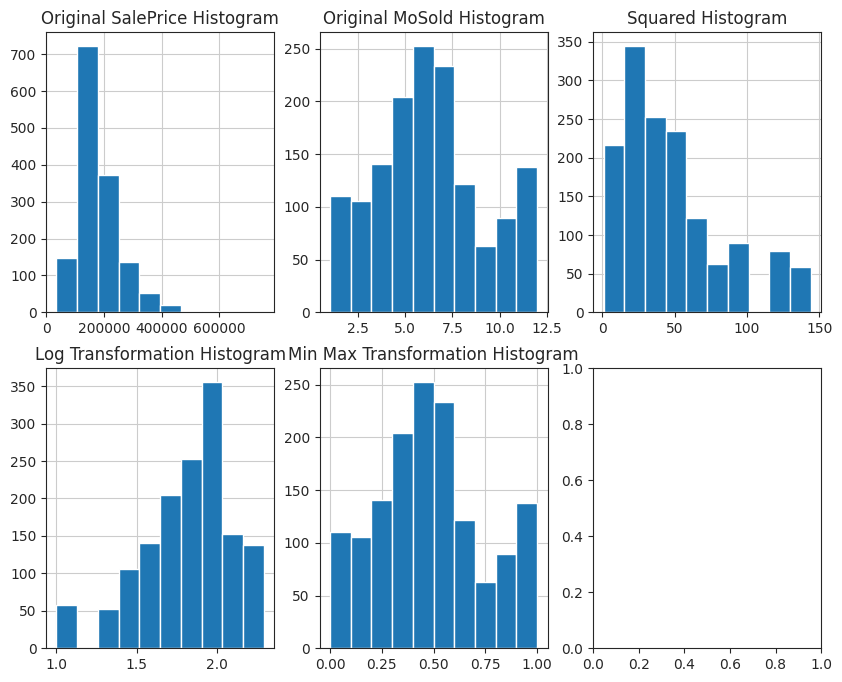

In [20]:
# can we find non linear realationships to sale price?
for feat in ['LandContour','OverallCond','MSSubClass','MoSold']:
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))

    temp = train[['SalePrice', feat]].copy()
    # Original histogram
    temp['SalePrice'].hist(ax=axes[0, 0])
    axes[0, 0].set_title('Original SalePrice Histogram')

    # Histogram of 'string_feat'
    temp[feat].hist(ax=axes[0, 1])
    axes[0, 1].set_title(f'Original {feat} Histogram')

    # square transformation
    temp[feat + '_sqr'] = temp[feat] * temp[feat]
    temp[feat + '_sqr'].hist(ax=axes[0, 2])
    axes[0, 2].set_title('Squared Histogram')

    # Log-transformed histogram
    temp[feat + '_log'] = np.cbrt(temp[feat])
    temp[feat + '_log'].hist(ax=axes[1, 0])
    axes[1, 0].set_title('Log Transformation Histogram')

    # min max transformation
    temp[feat + '_minmax'] = minmax_scaling(temp[[feat]], columns=[feat])
    temp[feat + '_minmax'].hist(ax=axes[1, 1])
    axes[1, 1].set_title('Min Max Transformation Histogram')


In [21]:
# perform a square root transformation on the overall condition
train['OveralCond_sqrt'] = np.sqrt(train['OverallCond'])
test['OveralCond_sqrt'] = np.sqrt(test['OverallCond'])

# perform a square root transformation on the overall condition
train['MSSubClass_sqrt'] = np.sqrt(train['MSSubClass'])
test['MSSubClass_sqrt'] = np.sqrt(test['MSSubClass'])

# perform a square transformation on the MoSold
train['MoSold_square'] = train['MoSold']*train['MoSold']
test['MoSold_square'] = test['MoSold']*test['MoSold']

<ipython-input-21-e1cd5e8e0b09>:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-21-e1cd5e8e0b09>:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-21-e1cd5e8e0b09>:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-21-e1cd5e8e0b09>:7: PerformanceWarning:

Da

In [22]:
# roll up the year built into decades
train['decade_built']=train.YearBuilt//10*10
train['decade_built']=np.where(train['YearBuilt']<1900,'1800s',train['decade_built'])

test['decade_built']=test.YearBuilt//10*10
test['decade_built']=np.where(test['YearBuilt']<1900,'1800s',test['decade_built'])

train['decade_built'].value_counts()

<ipython-input-22-cdf6dabd4d74>:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-22-cdf6dabd4d74>:5: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



decade_built
2000     387
1970     188
1960     175
1950     167
1990     163
1920      97
1940      79
1980      61
1910      58
1930      54
1900      15
1800s     15
2010       1
Name: count, dtype: int64

In [23]:
# create boolean feature for if the house has been remodeled
train['isRemodeled']=np.where(train['YearRemodAdd']==train['YearBuilt'],1,0)
test['isRemodeled']=np.where(test['YearRemodAdd']==test['YearBuilt'],1,0)
train['isRemodeled'].value_counts()

<ipython-input-23-eefca455d5ef>:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-23-eefca455d5ef>:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



isRemodeled
1    764
0    696
Name: count, dtype: int64

In [24]:
# does the house have any type of porch?
train['has_porch_deck']=np.where((train['WoodDeckSF']+train['OpenPorchSF']+train['EnclosedPorch']+train['3SsnPorch']+train['ScreenPorch'])>0,1,0)
test['has_porch_deck']=np.where((test['WoodDeckSF']+test['OpenPorchSF']+test['EnclosedPorch']+test['3SsnPorch']+test['ScreenPorch'])>0,1,0)
train['has_porch_deck'].value_counts()

<ipython-input-24-557a1b791463>:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-24-557a1b791463>:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



has_porch_deck
1    1206
0     254
Name: count, dtype: int64

In [25]:
# season that the house was last sold
# season according to the norther hemisphere
seasons={12:'winter',1:'winter',2:'winter',
        3:'spring',4:'spring',5:'spring',
        6:'summer',7:'summer',8:'summer',
        9:'fall',10:'fall',11:'fall'}
train['season_sold']=train.MoSold.map(seasons)
test['season_sold']=test.MoSold.map(seasons)
train['season_sold'].value_counts()

<ipython-input-25-33a9df5e8dfa>:7: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-25-33a9df5e8dfa>:8: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



season_sold
summer    609
spring    451
fall      231
winter    169
Name: count, dtype: int64

In [26]:
selected_features=[
#     Lot
    'MSZoning','LandSlope_Gtl','LotFrontage', 'LotArea',
    'LotShape','LandContour','LotConfig',
#     Neighborhood
    'Neighborhood','Street_Pave',
#     House Info
    'Condition1','OverallQual','OverallCond','Condition2_Norm',
    'BldgType','HouseStyle',  'OveralCond_sqrt','MSSubClass_sqrt',
    'decade_built', 'isRemodeled',
#     Exterior
    'RoofStyle', 'RoofMatl_CompShg','Functional_Typ','Exterior1st',
    'Exterior2nd', 'ExterQual', 'ExterCond','has_porch_deck',
#     Foundation
    'MasVnrType','MasVnrArea', 'Foundation',
#     Basement
    'BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1',
    'BsmtFinSF1',  'BsmtFinType2','BsmtUnfSF',
    'TotalBsmtSF',  'BsmtFullBath', 'BsmtFinSF2',
#     Utilities
    'HeatingQC','Utilities_AllPub',
    'Heating_GasA','CentralAir_Y',
#     Rooms
    '1stFlrSF','2ndFlrSF','LowQualFinSF',
    'GrLivArea','FullBath','HalfBath',
    'BedroomAbvGr','KitchenQual', 'TotRmsAbvGrd',
#     Fireplaces
    'Fireplaces', 'FireplaceQu',
#     Garage
    'GarageType', 'GarageYrBlt','GarageCond_TA',
    'GarageFinish', 'GarageCars', 'GarageArea',
    'GarageQual',
#     Extra Amenities
    'PoolArea', 'Fence','MiscVal',
#     Sales
    'SaleType','SaleCondition',
    'MoSold_square','season_sold'
]

numerical_features=['GarageYrBlt','MSSubClass_sqrt','LotArea','GarageArea',
 'BsmtUnfSF','TotalBsmtSF','2ndFlrSF','PoolArea','1stFlrSF',
 'LotFrontage','BsmtFinSF2','LowQualFinSF','BsmtFinSF1',
 'MasVnrArea','MiscVal','GrLivArea','MoSold_square']

categorical_features=list(set(selected_features)-set(numerical_features))

# **Predict Housing Prices using XGBoost**

In [27]:
#Setup data pipeline
numerical_pipeline = Pipeline([('std_scaler', StandardScaler()),
                         ('imputer', SimpleImputer(strategy='constant',fill_value=0))])
categorical_pipeline = Pipeline([('encoding', OneHotEncoder(handle_unknown='ignore', drop='if_binary', sparse=False))])
data_pipeline = ColumnTransformer([('numerical', numerical_pipeline, numerical_features),('categorical', categorical_pipeline, categorical_features)])

# get the target array and the features
y = train[['SalePrice']]
X = train[selected_features]

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1,random_state=123)

In [28]:
# XGBoost Gridsearch
regressors =[XGBRegressor(n_estimators = 1500, learning_rate = 0.001, weight=0.01, max_depth = 3,min_child_weight=2, random_state = 123),
            XGBRegressor(n_estimators = 2000, learning_rate = 0.001, weight=0.01, max_depth = 3,min_child_weight=2, random_state = 123),
            XGBRegressor(n_estimators = 3000, learning_rate = 0.001, weight=0.01, max_depth = 3,min_child_weight=2, random_state = 123),
            XGBRegressor(n_estimators = 5000, learning_rate = 0.05, weight=0.01, max_depth = 3,min_child_weight=2 ,random_state = 123),
            XGBRegressor(n_estimators = 10000, learning_rate = 0.05, weight=0.01, max_depth = 3,min_child_weight=2 ,random_state = 123),
            XGBRegressor(n_estimators = 1500, learning_rate = 0.1, weight=0.01, max_depth = 3,random_state = 123),
            XGBRegressor(n_estimators = 1500, learning_rate = 0.1, weight=0.01, max_depth = 3,gamma = 0, random_state = 123),
            XGBRegressor(n_estimators = 1500, learning_rate = 0.01, weight=0.01, max_depth = 3,gamma = 0, random_state = 123),
            XGBRegressor(n_estimators = 1500, learning_rate = 0.01, weight=0.1, max_depth = 3,gamma = 0, random_state = 123),
            XGBRegressor(n_estimators = 1500, learning_rate = 0.001, weight=0.1, max_depth = 3,gamma = 0, random_state = 123),
            XGBRegressor(n_estimators = 1500, learning_rate = 0.01, weight=0.1, max_depth = 6,gamma = 0, random_state = 123),
            XGBRegressor(n_estimators = 1500, learning_rate = 0.001, weight=0.1, max_depth = 6,gamma = 0, random_state = 123),
            XGBRegressor(n_estimators = 1500, learning_rate = 0.01, weight=0.1, max_depth = 9,gamma = 0, random_state = 123),
            XGBRegressor(n_estimators = 1500, learning_rate = 0.001, weight=0.1, max_depth = 9,gamma = 0, random_state = 123)]

cvfold = KFold(n_splits=5, shuffle=True, random_state=123)

for regressor in regressors:
    print(f'regressor: {regressor}')
    pipeline = Pipeline(steps =[('preprocessor', data_pipeline),('regressor', regressor)])

    # Fit the model on the training data
    pipeline.fit(X_train, y_train)

    # Predict using the fitted model on the test data
    y_pred = pipeline.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    print(f"RMSE: {round(np.sqrt(mse),4)}")

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1500, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[17:28:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "weight" } are not used.




RMSE: 42956.4849
regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[17:28:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "weight" } are not used.




RMSE: 37237.228
regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3000, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[17:28:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "weight" } are not used.




RMSE: 30658.9877
regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5000, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[17:28:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "weight" } are not used.




RMSE: 23490.6223
regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[17:29:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "weight" } are not used.




RMSE: 23542.7686
regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1500, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[17:29:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "weight" } are not used.




RMSE: 22800.8413
regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1500, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[17:29:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "weight" } are not used.




RMSE: 22800.8413
regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1500, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[17:29:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "weight" } are not used.




RMSE: 23399.943
regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1500, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[17:29:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "weight" } are not used.




RMSE: 23399.943
regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1500, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[17:29:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "weight" } are not used.




RMSE: 42972.667
regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1500, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[17:29:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "weight" } are not used.




RMSE: 26536.8799
regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1500, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[17:29:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "weight" } are not used.




RMSE: 41828.9543
regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1500, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[17:29:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "weight" } are not used.




RMSE: 29118.3721
regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1500, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[17:30:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "weight" } are not used.




RMSE: 41427.9621


In [29]:
regressor=XGBRegressor(n_estimators = 1500, learning_rate = 0.1, weight=0.01, max_depth = 3,gamma = 0, random_state = 123)
pipeline = Pipeline(steps =[('preprocessor', data_pipeline),('regressor', regressor)])

# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Predict using the fitted model on the test data
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"RMSE: {round(np.sqrt(mse),4)}")

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[17:30:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "weight" } are not used.




RMSE: 22800.8413


In [30]:
regressor=XGBRegressor(n_estimators = 1500, learning_rate = 0.1, weight=0.01, max_depth = 3,gamma = 0, random_state = 123)
pipeline = Pipeline(steps =[('preprocessor', data_pipeline),('regressor', regressor)])

# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Predict using the fitted model on the test data
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"RMSE: {round(np.sqrt(mse),4)}")

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[17:30:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "weight" } are not used.




RMSE: 22800.8413


In [31]:
X = test[selected_features]

test_pred = pipeline.predict(test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning:

Found unknown categories in columns [1, 2, 3, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 29, 32, 34, 35, 36, 39, 40, 41, 42, 43, 44, 45, 46, 48, 51] during transform. These unknown categories will be encoded as all zeros



In [32]:
X = test[selected_features]

test_pred = pipeline.predict(test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning:

Found unknown categories in columns [1, 2, 3, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 29, 32, 34, 35, 36, 39, 40, 41, 42, 43, 44, 45, 46, 48, 51] during transform. These unknown categories will be encoded as all zeros



In [35]:
submission=test[['Id']].copy()
submission['SalePrice']=test_pred
submission.head()

,Id,SalePrice
0,1461,131958.437500
1,1462,173375.468750
2,1463,188021.390625
3,1464,185523.437500
4,1465,164094.734375


In [36]:
submission.to_csv('/content/drive/MyDrive/Prodigy InfoTech/PRODIGY_ML_01/sample_submission.csv',index=False)